In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

dataFileName  = "input/NizhnyNovgorod.csv"
allDataFrame = loadData( dataFileName, COLUMN_TYPE='NUMERICAL' )
allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


,price,longitude,latitude,total_square,number_of_rooms,number_of_floors
0,2850000.0,44.075417,56.283864,43.0,1,17
1,8200000.0,43.942485,56.301539,98.5,3,17
2,2600000.0,43.923782,56.310448,64.0,4,5
3,2750000.0,44.064952,56.291499,50.0,2,5
4,2650000.0,43.957127,56.329128,45.0,2,5
5,2400000.0,44.023674,56.316345,76.0,2,9
6,3700000.0,43.996545,56.317807,45.0,2,8
7,3550000.0,44.079100,56.303541,41.8,1,9
9,1900000.0,44.001350,56.310740,57.0,1,12
11,2800000.0,44.001350,56.310740,91.0,3,12


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors
count,2.282600e+04,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000
mean,3.497002e+06,43.944338,56.298380,57.031991,2.099010,10.572680
std,1.959918e+06,0.080739,0.039747,25.354327,0.945717,6.126015
min,5.500000e+05,43.704484,56.116292,12.900000,1.000000,1.000000
25%,2.300000e+06,43.872148,56.269071,40.700000,1.000000,5.000000
50%,3.000000e+06,43.945310,56.302348,52.000000,2.000000,9.000000
75%,4.179320e+06,44.014655,56.326887,67.600000,3.000000,16.000000
max,4.000000e+07,44.209706,56.399252,480.000000,9.000000,28.000000


In [3]:
import torch
import _pickle as cPickle
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       
Y_values    = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); 
X_dataFrame = X_dataFrame[['longitude','latitude','total_square','number_of_rooms','number_of_floors']]
X_values    = X_dataFrame.values;
Y_values    = Y_values.ravel()

device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
Model = None
with open( "model.pkl", 'rb') as fid:
    Model = cPickle.load(fid)
preprocessorX = None
with open( 'preprocessorX.pkl', 'rb') as fid:
    preprocessorX = cPickle.load(fid)
preprocessorY = None
with open( 'preprocessorY.pkl', 'rb') as fid:
    preprocessorY = cPickle.load(fid)

X_numpy = preprocessorX.transform( X_values )
 
X_torch = torch.from_numpy( X_numpy.astype( np.float32 ) ).to( device )
Y_torch = Model( X_torch )
Y_predict = Y_torch.detach().numpy()
Y_predict = preprocessorY.inverse_transform( Y_predict ).ravel()

print( Y_predict )
print( Y_values  )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

[2878970.2 7051923.5 2953500.8 ... 1440552.6 4942249.5 5341822.5]
[2850000. 8200000. 2600000. ... 1290000. 5499900. 3841000.]
Errors on the test set
mean square:      512877135654.40515
mean absolute:    391970.94322332536
median_absolute:  235078.375


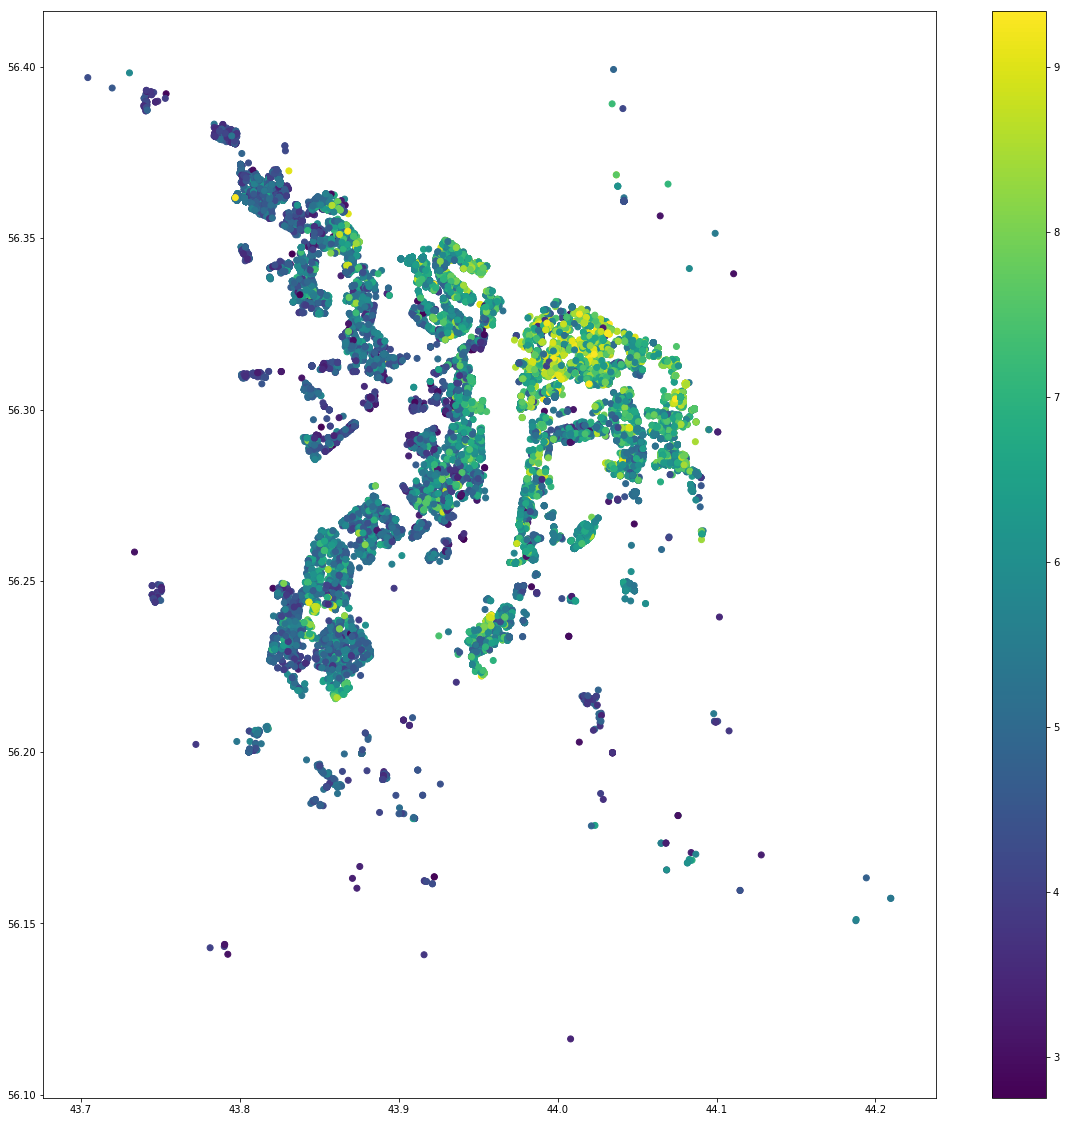

In [4]:
pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

x = X_values[:,0]; y = X_values[:,1];

plt.figure(figsize=(20,20))
plt.scatter (x, y, c=pricePerSquareValues/10000  )
plt.colorbar()


[2878970.2 7051923.5 2953500.8 ... 1440552.6 4942249.5 5341822.5]
[2850000. 8200000. 2600000. ... 1290000. 5499900. 3841000.]
threshold =   2.5, good =       4169, bad =      18657, err = 0.8173573994567598
threshold =   5.0, good =       7843, bad =      14983, err = 0.6564005958117936
threshold =  10.0, good =      13524, bad =       9302, err = 0.40751774292473497
threshold =  15.0, good =      17271, bad =       5555, err = 0.24336283185840707
62 62
1497 1497


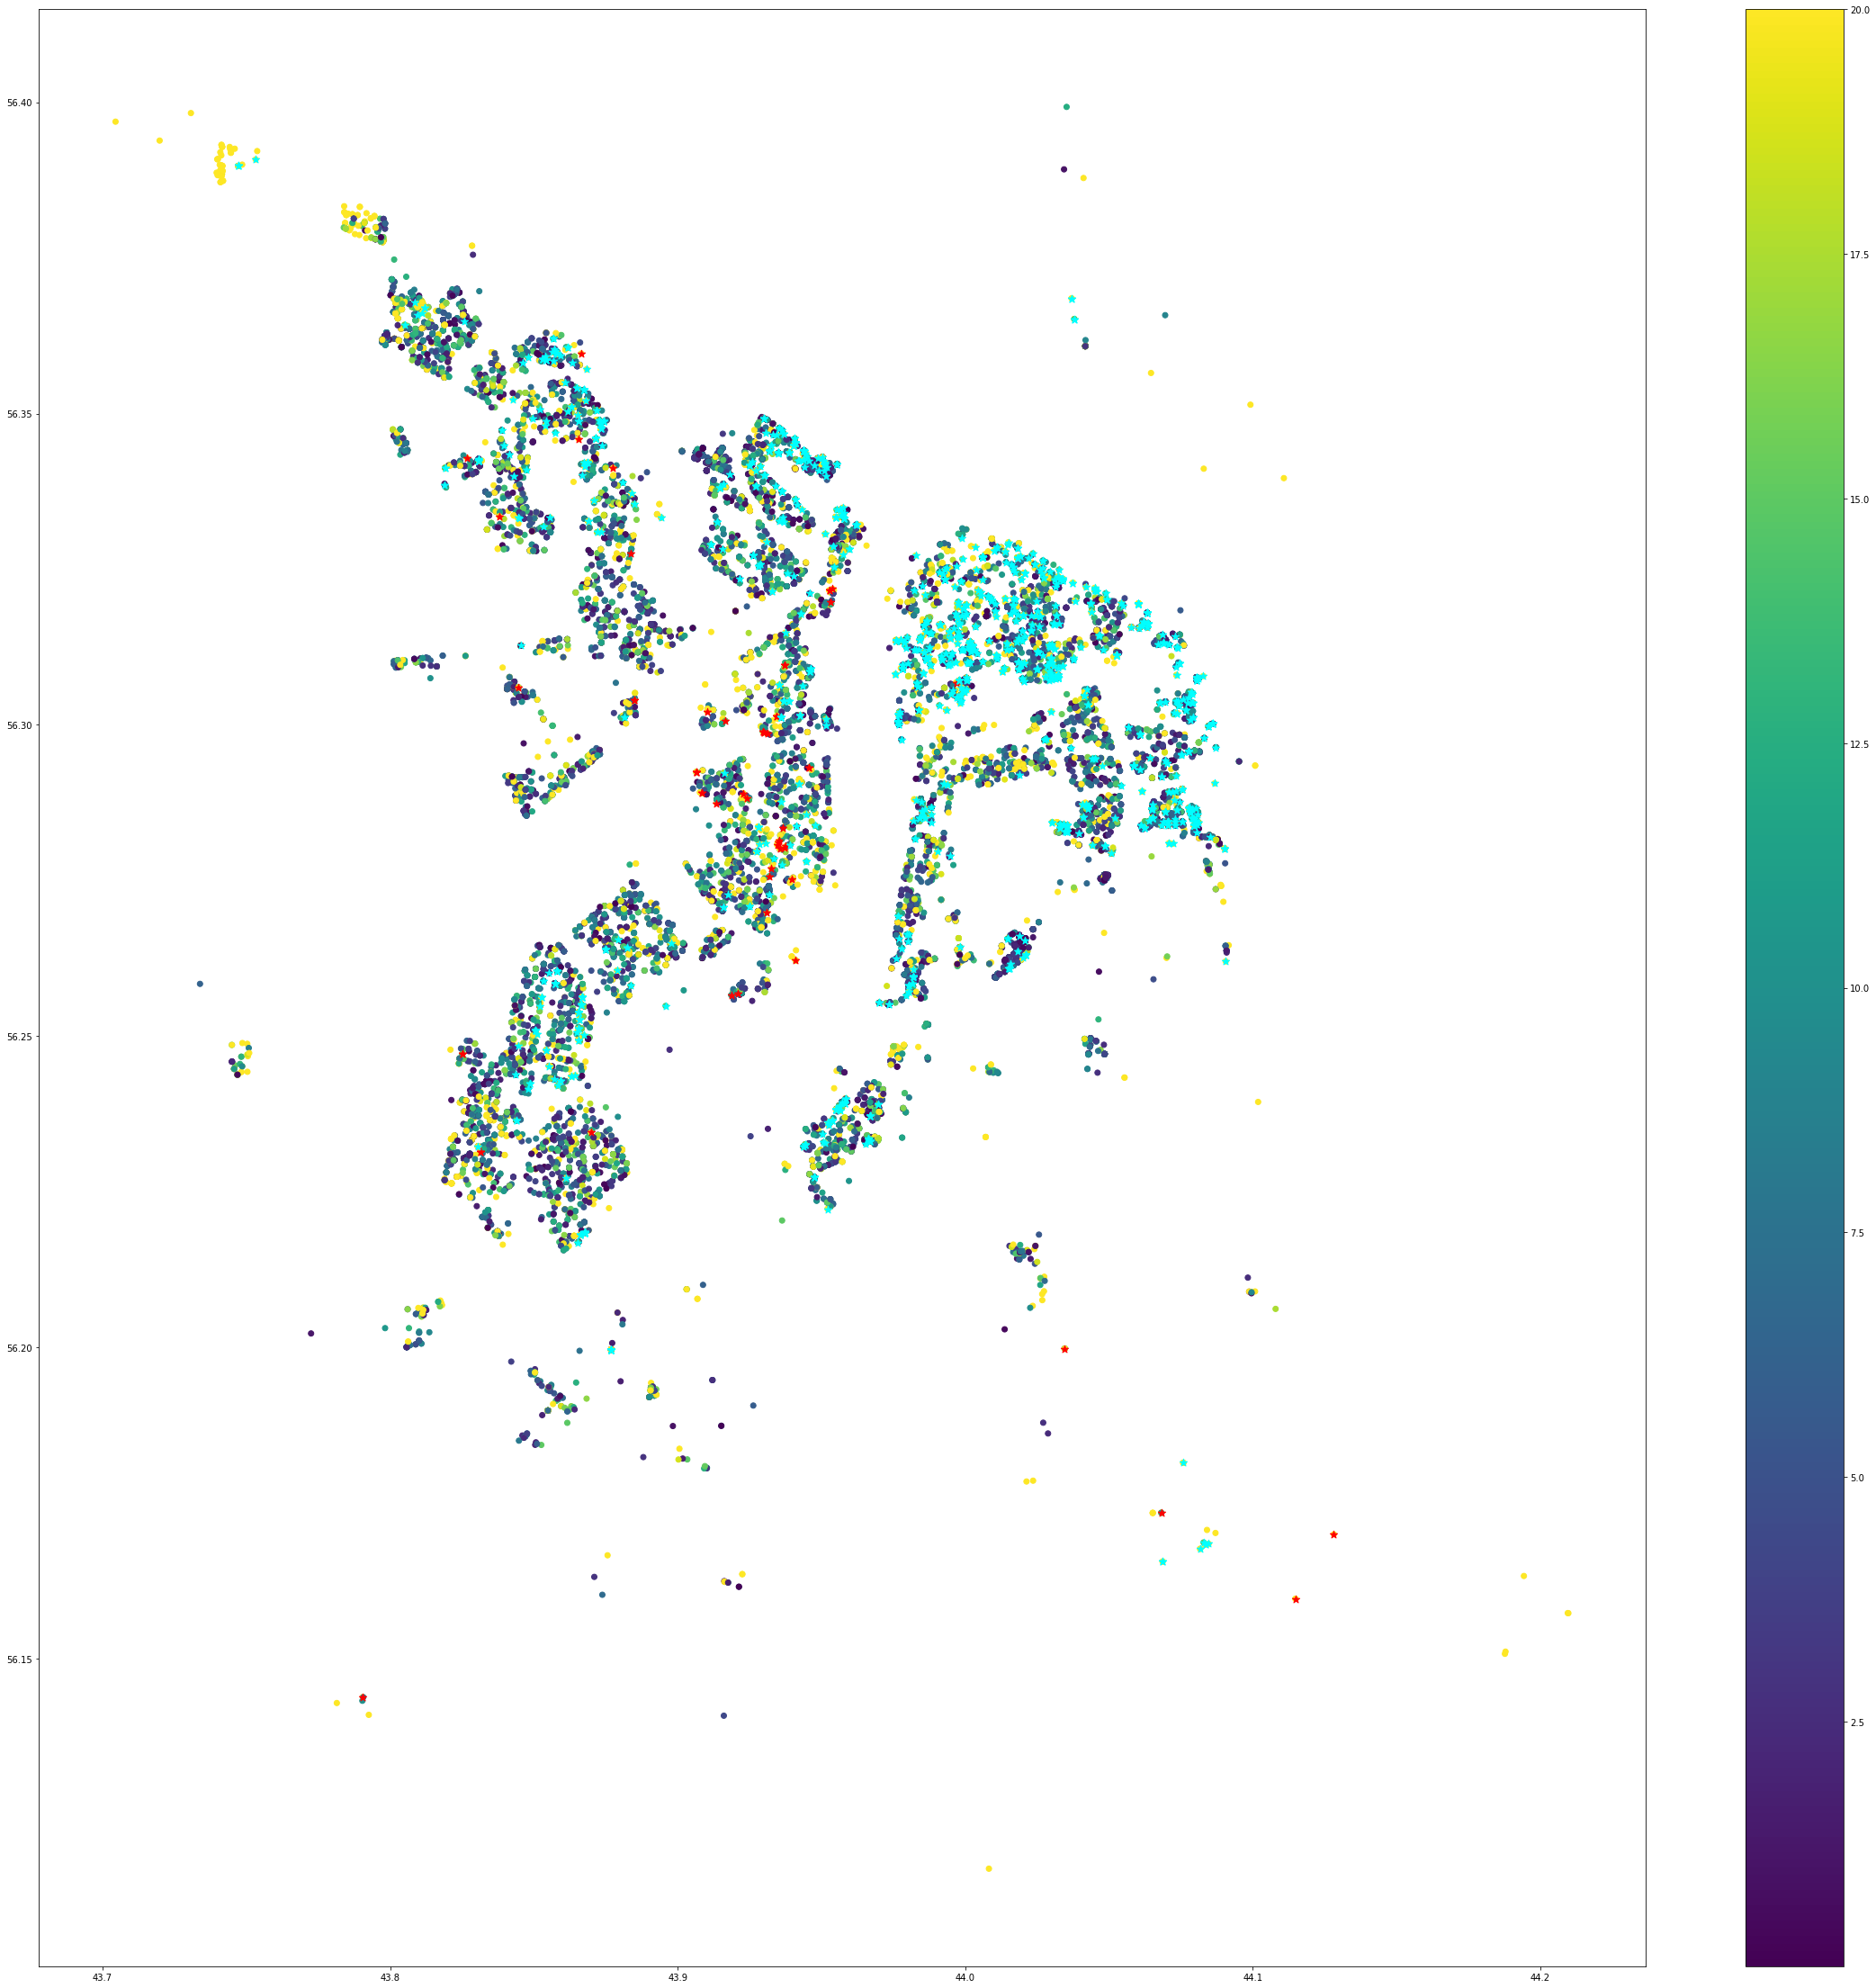

             price  longitude   latitude  total_square  number_of_rooms  \
1        8200000.0  43.942485  56.301539         98.50                3   
29       5500000.0  44.032136  56.307566         60.00                1   
140      8600000.0  43.943823  56.344062        114.00                5   
231      8000000.0  43.941541  56.335316         88.00                3   
265      5950000.0  44.032954  56.283440         98.00                3   
300      5170000.0  43.897847  56.264882         94.00                3   
348      5200000.0  44.035469  56.282800         70.00                2   
368      7800000.0  43.927195  56.338310         90.00                3   
376      6950000.0  44.063470  56.316284         82.30                3   
419      6700000.0  43.962301  56.332167         76.00                3   
424     11999999.0  44.061511  56.289320        230.00                6   
425      5900000.0  43.982208  56.321646         92.10                4   
495      5450640.0  43.99

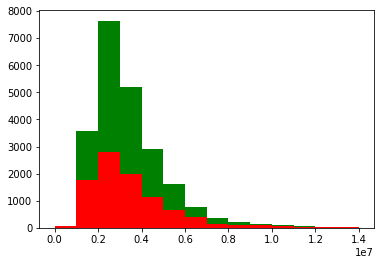

Плохие  примеры [  62. 1758. 2799. 1982. 1152.  659.  385.  153.  109.   90.   48.   33.
   22.   14.]
Хорошие примеры [  70. 3589. 7643. 5213. 2891. 1617.  750.  370.  222.  149.   96.   66.
   41.   34.]
Отношение       [1.12903226 2.04152446 2.73061808 2.63017154 2.50954861 2.45371775
 1.94805195 2.41830065 2.03669725 1.65555556 2.         2.
 1.86363636 2.42857143]
9302
13524


In [9]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

print( Y_predict )
print( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0, 15.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 20 );

plt.figure(figsize=(40,40))
plt.scatter (x, y, c=c  )
plt.colorbar()

mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
print( x_low.size , y_low.size  )
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
print( x_high.size, y_high.size )
plt.show    ()

print( allDataFrame[ mask ] )

threshold = 10
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.]
bins = [i * 1e6 for i in bins]

n = plt.hist([badTestDataValues, goodTestDataValues], bins=bins, histtype='barstacked', color=['red','green'], label = ['bad', 'good'])
plt.show()

#plt.scatter(Y_values,Y_predict)
#plt.plot   (Y_values,Y_values )
#plt.show   ()

print('Плохие  примеры', n[0][0] )
print('Хорошие примеры', n[0][1] )
print('Отношение      ', n[0][1]/n[0][0])

print( len( badTestDataValues ) )
print( len( goodTestDataValues ) )

In [6]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
price               3.000000e+06
longitude           4.402099e+01
latitude            5.631818e+01
total_square        1.000000e+02
number_of_rooms     3.000000e+00
number_of_floors    8.000000e+00
Name: 8895, dtype: float64
CLOSEST record
price               3.000000e+06
longitude           4.402099e+01
latitude            5.631818e+01
total_square        1.000000e+02
number_of_rooms     3.000000e+00
number_of_floors    8.000000e+00
Name: 8895, dtype: float64

BASE record
price               2.400000e+06
longitude           4.402367e+01
latitude            5.631634e+01
total_square        7.600000e+01
number_of_rooms     2.000000e+00
number_of_floors    9.000000e+00
Name: 5, dtype: float64
CLOSEST record
price               2.400000e+06
longitude           4.402367e+01
latitude            5.631634e+01
total_square        7.600000e+01
number_of_rooms     2.000000e+00
number_of_floors    9.000000e+00
Name: 5, dtype: float64

BASE record
price               2.470000e+06
longi

CLOSEST record
price               3.200000e+06
longitude           4.400599e+01
latitude            5.632688e+01
total_square        4.260000e+01
number_of_rooms     1.000000e+00
number_of_floors    1.700000e+01
Name: 6391, dtype: float64
CLOSEST record
price               2.360000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.500000e+01
number_of_rooms     2.000000e+00
number_of_floors    5.000000e+00
Name: 6436, dtype: float64
CLOSEST record
price               2.360000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        6.300000e+01
number_of_rooms     3.000000e+00
number_of_floors    2.000000e+00
Name: 6437, dtype: float64
CLOSEST record
price               4.400000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        5.180000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.600000e+01
Name: 6558, dtype: float64
CLOSEST record
price               2.300

Name: 12591, dtype: float64
CLOSEST record
price               2.650000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        3.000000e+01
number_of_rooms     1.000000e+00
number_of_floors    9.000000e+00
Name: 12597, dtype: float64
CLOSEST record
price               2.700000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.330000e+01
number_of_rooms     2.000000e+00
number_of_floors    9.000000e+00
Name: 12609, dtype: float64
CLOSEST record
price               3.050000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.750000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.700000e+01
Name: 12613, dtype: float64
CLOSEST record
price               3.250000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        5.330000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.000000e+01
Name: 12614, dtype: float64
CLOSEST 

CLOSEST record
price               3.500000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        6.050000e+01
number_of_rooms     3.000000e+00
number_of_floors    9.000000e+00
Name: 22845, dtype: float64
CLOSEST record
price               1.050000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        2.680000e+01
number_of_rooms     1.000000e+00
number_of_floors    3.000000e+00
Name: 22973, dtype: float64
CLOSEST record
price               3.550000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        5.500000e+01
number_of_rooms     2.000000e+00
number_of_floors    9.000000e+00
Name: 23276, dtype: float64
CLOSEST record
price               4.700000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        6.790000e+01
number_of_rooms     3.000000e+00
number_of_floors    1.000000e+01
Name: 23387, dtype: float64
CLOSEST record
price               1

Name: 45512, dtype: float64
CLOSEST record
price               2.750000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.280000e+01
number_of_rooms     1.000000e+00
number_of_floors    9.000000e+00
Name: 46710, dtype: float64
CLOSEST record
price               2.999000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.100000e+01
number_of_rooms     1.000000e+00
number_of_floors    1.200000e+01
Name: 46786, dtype: float64
CLOSEST record
price               1.850000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        3.330000e+01
number_of_rooms     1.000000e+00
number_of_floors    3.000000e+00
Name: 46788, dtype: float64
CLOSEST record
price               6.900000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        7.730000e+01
number_of_rooms     2.000000e+00
number_of_floors    9.000000e+00
Name: 47157, dtype: float64
CLOSEST 

CLOSEST record
price               1.030000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        3.400000e+01
number_of_rooms     2.000000e+00
number_of_floors    2.000000e+00
Name: 70865, dtype: float64
CLOSEST record
price               2.100000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.430000e+01
number_of_rooms     2.000000e+00
number_of_floors    5.000000e+00
Name: 70927, dtype: float64
CLOSEST record
price               5.275000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        7.100000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.000000e+01
Name: 72271, dtype: float64
CLOSEST record
price               3.500000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        7.440000e+01
number_of_rooms     3.000000e+00
number_of_floors    3.000000e+00
Name: 72799, dtype: float64
CLOSEST record
price               1

Name: 86328, dtype: float64
CLOSEST record
price               2.060000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        6.000000e+01
number_of_rooms     2.000000e+00
number_of_floors    5.000000e+00
Name: 86362, dtype: float64
CLOSEST record
price               4.750000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        8.460000e+01
number_of_rooms     4.000000e+00
number_of_floors    4.000000e+00
Name: 86843, dtype: float64
CLOSEST record
price               3.090000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        4.300000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.600000e+01
Name: 86845, dtype: float64
CLOSEST record
price               3.120000e+06
longitude           4.400599e+01
latitude            5.632689e+01
total_square        6.390000e+01
number_of_rooms     3.000000e+00
number_of_floors    9.000000e+00
Name: 86847, dtype: float64
CLOSEST 

CLOSEST record
price               3.150000e+06
longitude           4.400750e+01
latitude            5.632690e+01
total_square        6.070000e+01
number_of_rooms     4.000000e+00
number_of_floors    9.000000e+00
Name: 2654, dtype: float64
CLOSEST record
price               1.250000e+06
longitude           4.400750e+01
latitude            5.632690e+01
total_square        3.000000e+01
number_of_rooms     1.000000e+00
number_of_floors    5.000000e+00
Name: 15070, dtype: float64
CLOSEST record
price               2.687000e+06
longitude           4.400750e+01
latitude            5.632690e+01
total_square        4.300000e+01
number_of_rooms     1.000000e+00
number_of_floors    1.000000e+01
Name: 17106, dtype: float64
CLOSEST record
price               2.900000e+06
longitude           4.400750e+01
latitude            5.632690e+01
total_square        8.600000e+01
number_of_rooms     4.000000e+00
number_of_floors    4.000000e+00
Name: 20423, dtype: float64
CLOSEST record
price               3.


BASE record
price               2.217600e+06
longitude           4.386395e+01
latitude            5.636099e+01
total_square        6.700000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.600000e+01
Name: 17701, dtype: float64
CLOSEST record
price               2.217600e+06
longitude           4.386395e+01
latitude            5.636099e+01
total_square        6.700000e+01
number_of_rooms     2.000000e+00
number_of_floors    1.600000e+01
Name: 17701, dtype: float64

BASE record
price               1.555000e+06
longitude           4.418765e+01
latitude            5.615080e+01
total_square        2.900000e+01
number_of_rooms     1.000000e+00
number_of_floors    9.000000e+00
Name: 3398, dtype: float64
CLOSEST record
price               1.555000e+06
longitude           4.418765e+01
latitude            5.615080e+01
total_square        2.900000e+01
number_of_rooms     1.000000e+00
number_of_floors    9.000000e+00
Name: 3398, dtype: float64



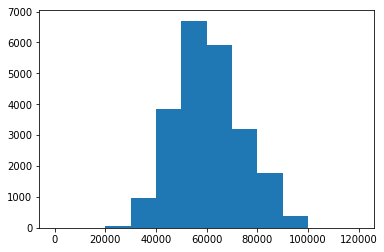

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()
